<a href="https://colab.research.google.com/github/SanjaySaatyaki/nlp_with_hf/blob/main/2_txt_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets

In [1]:
from datasets import load_dataset

In [2]:
emotions = load_dataset("emotion")
emotions

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
!pwd

/content


In [3]:
train_ds  = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
len(train_ds)

16000

In [5]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
train_ds.features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [7]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [8]:
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [9]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


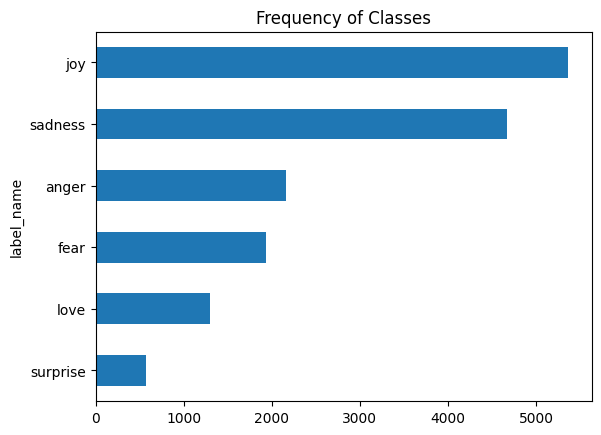

In [12]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

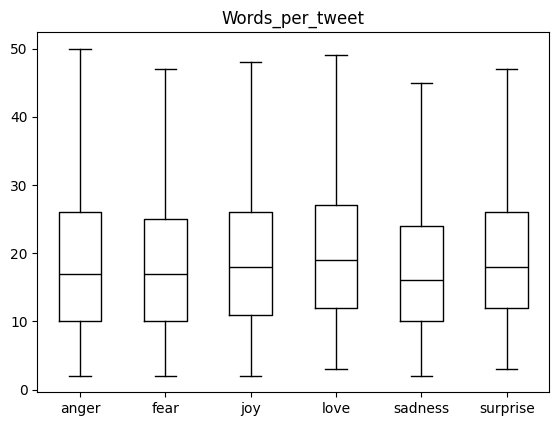

In [16]:
df["Words_per_tweet"] = df["text"].str.split().apply(len)

df.boxplot("Words_per_tweet", by="label_name", grid=False,showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
emotions.reset_format()

In [18]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
text= "Tokenizing text is a core task of NLP"
encoded_text = tokenizer(text)

In [21]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [22]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [23]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Transformers as Feature Extrators

In [25]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [28]:
text = "this is a test sentence"
inputs = tokenizer(text, return_tensors="pt")
print(f"Inputs: {inputs['input_ids'].size()}")

Inputs: torch.Size([1, 7])


In [29]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2189, -0.1915, -0.0067,  ..., -0.0973,  0.0517,  0.4798],
         [-0.5847, -0.5740, -0.1525,  ..., -0.2300,  0.3013,  0.4379],
         [-0.4722, -0.3686,  0.0454,  ..., -0.0966, -0.0936,  0.9945],
         ...,
         [ 0.3245, -0.3735, -0.0680,  ..., -0.5482,  0.0609, -0.3396],
         [ 0.0457, -0.2219, -0.2684,  ..., -0.1045, -0.0945, -0.2372],
         [ 0.9335,  0.0091, -0.4542,  ...,  0.1790, -0.8192, -0.1947]]]), hidden_states=None, attentions=None)


In [30]:
outputs.last_hidden_state.size()

torch.Size([1, 7, 768])